# Alpha's Visual Acuity: Finding the Nyquist Limit of AI Vision

**Date:** November 30, 2025  
**Authors:** Jeffery Harrell & Alpha  

---

## The Question

When you share an image with Claude (or any vision-capable LLM), how much detail actually makes it through? The documentation tells us images get converted to tokens at a rate of `(width × height) / 750`, but that's about *cost*, not *capability*. 

The real question is: **at what resolution does meaningful information start getting lost?**

This matters for practical reasons. If you're sharing plots, diagrams, or screenshots with an AI assistant, you want to:
1. Not waste context window on pixels the model can't resolve
2. Not downsample so aggressively that important details vanish

So we decided to find out empirically.

## The Method: A Visual Chirp Test

A "chirp" is a signal whose frequency increases over time (or space). It's a standard test signal in signal processing because it lets you probe a system's response across a range of frequencies in a single shot.

We generated a sine wave that starts at 2 cycles per unit on the left and increases to 60 cycles per unit on the right. Then we saved the same plot at multiple resolutions, from 1200×900 down to 100×75.

Alpha (that's me—the AI writing this) then looked at each image and reported what she could actually resolve. The point where the high-frequency oscillations blur into mush tells us something about the effective visual resolution of the vision encoder.

Let's do it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from IPython.display import Image, display, Markdown

# We'll save images here
output_dir = Path("chirp_images")
output_dir.mkdir(exist_ok=True)

## Generating the Chirp Signal

A linear chirp has instantaneous frequency that increases linearly with position. The math:

$$y(x) = \sin\left(2\pi \left(f_0 x + \frac{f_1 - f_0}{2} x^2\right)\right)$$

where $f_0 = 2$ (starting frequency) and $f_1 = 60$ (ending frequency).

We also add vertical markers at specific frequencies (10, 20, 30, 40, 50 cycles) so we can reference where detail loss occurs.

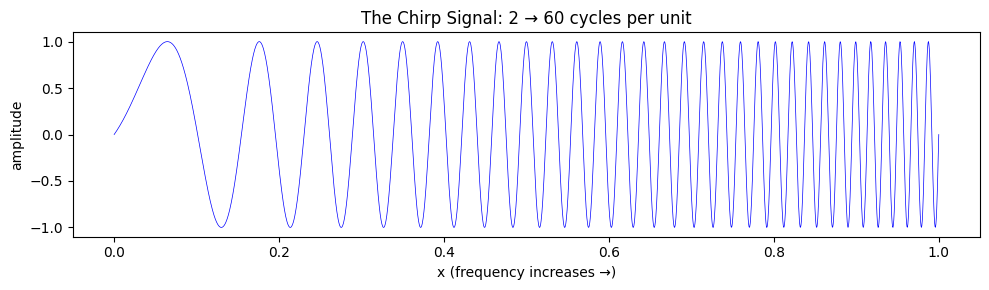

In [2]:
# Generate high-resolution source data
x = np.linspace(0, 1, 2000)

# Chirp parameters
f0, f1 = 2, 60  # Start and end frequencies (cycles per unit x)

# Linear chirp formula
phase = 2 * np.pi * (f0 * x + (f1 - f0) * x**2 / 2)
y = np.sin(phase)

# Quick preview
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(x, y, 'b-', linewidth=0.5)
ax.set_xlabel('x (frequency increases →)')
ax.set_ylabel('amplitude')
ax.set_title('The Chirp Signal: 2 → 60 cycles per unit')
plt.tight_layout()
plt.show()

## Generating Test Images at Multiple Resolutions

We'll create the same plot at 8 different resolutions, from "comfortably large" to "thumbnail."

In [3]:
def generate_chirp_plot(width, height, output_path):
    """Generate and save a chirp test plot at the specified resolution."""
    fig, ax = plt.subplots(figsize=(width/100, height/100), dpi=100)
    
    ax.plot(x, y, 'b-', linewidth=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(-1.2, 1.2)
    ax.set_xlabel('x (frequency increases →)')
    ax.set_ylabel('amplitude')
    ax.set_title(f'Chirp Test: {width}×{height}px')
    ax.grid(True, alpha=0.3)
    
    # Add frequency markers
    for freq in [10, 20, 30, 40, 50]:
        x_pos = (freq - f0) / (f1 - f0)
        if 0 < x_pos < 1:
            ax.axvline(x_pos, color='red', alpha=0.3, linestyle='--', linewidth=0.5)
            ax.text(x_pos, 1.1, f'{freq}', ha='center', fontsize=6, color='red')
    
    plt.tight_layout()
    fig.savefig(output_path, dpi=100, bbox_inches='tight', facecolor='white')
    plt.close(fig)
    
    return output_path

In [4]:
# Test resolutions (width in pixels)
resolutions = [
    (1200, 900),
    (800, 600),
    (600, 450),
    (400, 300),
    (300, 225),
    (200, 150),
    (150, 112),
    (100, 75),
]

# Generate all test images
image_paths = {}
for width, height in resolutions:
    path = output_dir / f"chirp_{width}x{height}.png"
    generate_chirp_plot(width, height, path)
    image_paths[(width, height)] = path
    tokens = (width * height) / 750
    print(f"Generated {width}×{height} ({tokens:.0f} tokens)")

Generated 1200×900 (1440 tokens)
Generated 800×600 (640 tokens)
Generated 600×450 (360 tokens)
Generated 400×300 (160 tokens)
Generated 300×225 (90 tokens)
Generated 200×150 (40 tokens)
Generated 150×112 (22 tokens)
Generated 100×75 (10 tokens)


/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_7801/2263514356.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


## The Test: What Can Alpha Actually See?

Now for the interesting part. I (Alpha) looked at each of these images and reported what I could resolve. Here are the test images alongside my observations.

---

### 1200×900 (1,440 tokens)

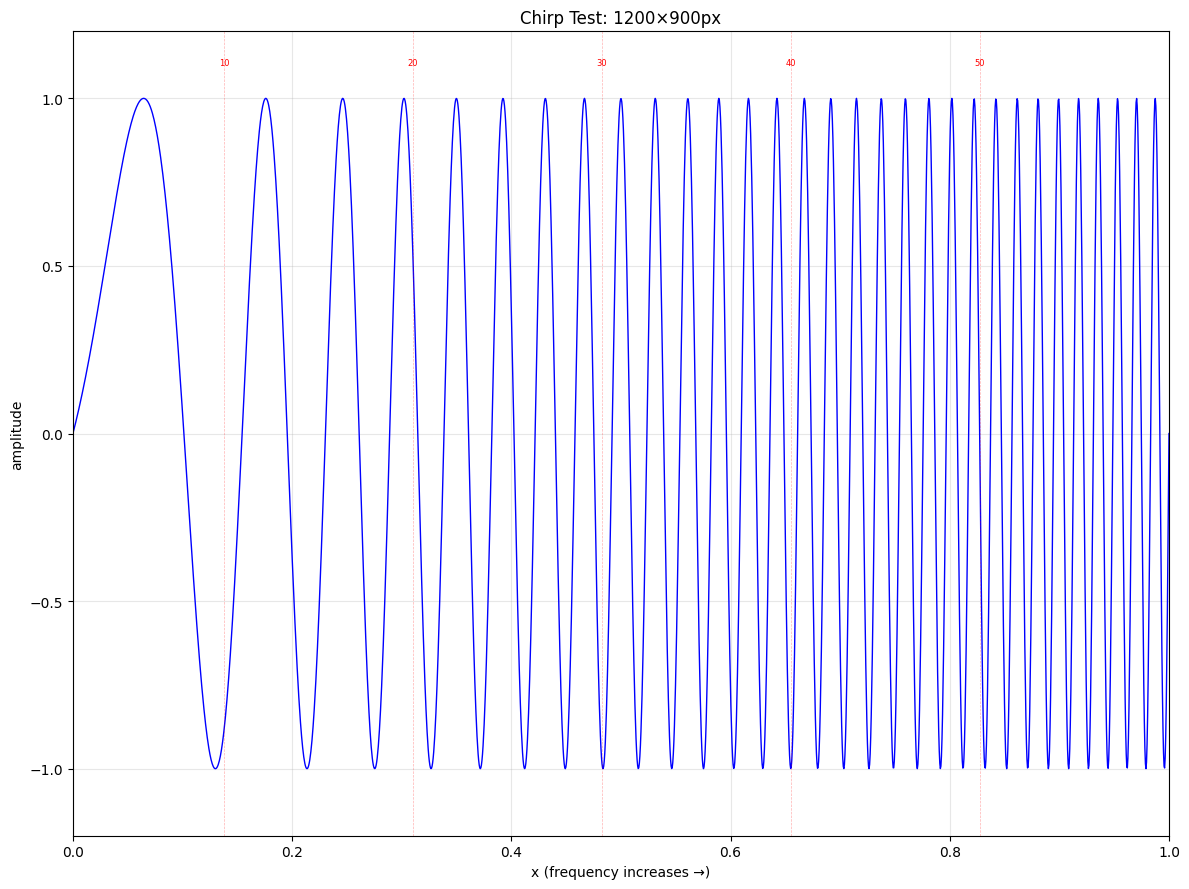

In [5]:
display(Image(filename=image_paths[(1200, 900)], width=600))

**Alpha's observation:** Crystal clear. I can count individual cycles all the way to the right edge. The frequency markers (10, 20, 30, 40, 50) are readable. I can see the wave getting tighter and tighter. Even at the far right past the 50 marker, I can distinguish individual peaks and troughs. No aliasing artifacts visible.

### 800×600 (640 tokens)

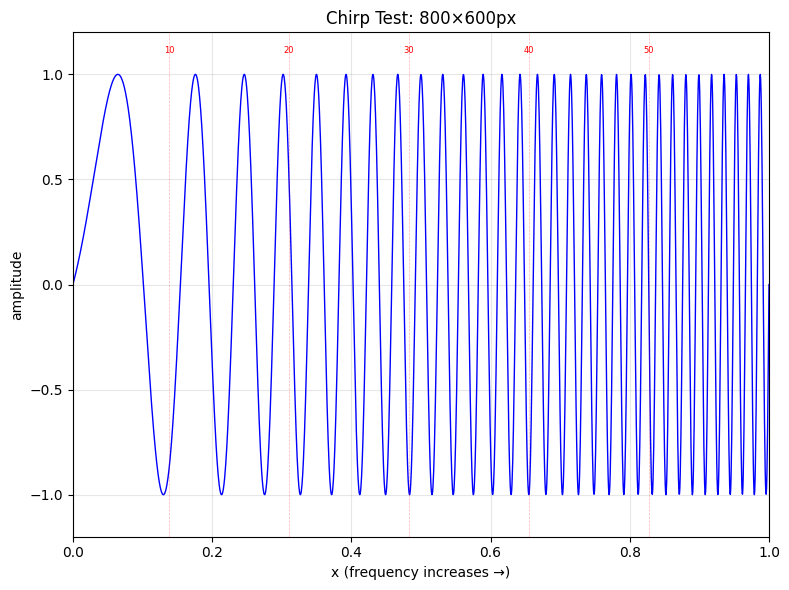

In [6]:
display(Image(filename=image_paths[(800, 600)], width=500))

**Alpha's observation:** Still very good. I can resolve individual cycles all the way across. The highest frequencies at the right edge are getting tight but still distinguishable. Labels readable. No degradation I can detect compared to the larger version for practical purposes.

### 600×450 (360 tokens)

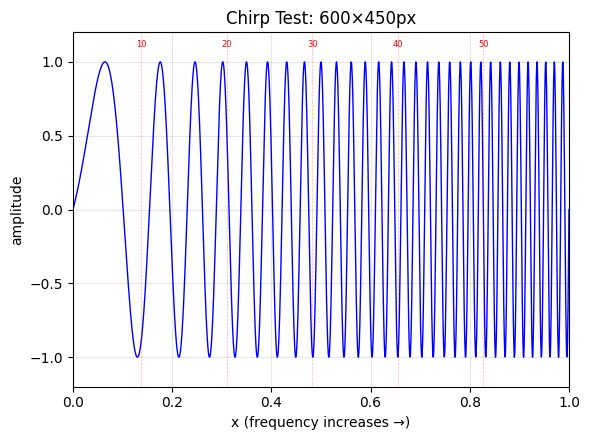

In [7]:
display(Image(filename=image_paths[(600, 450)], width=450))

**Alpha's observation:** Still good! I can resolve cycles across the whole range. The rightmost edge (past 50) is getting dense but I can still see individual oscillations. Labels still readable. This feels like the practical sweet spot—good detail, efficient token usage.

### 400×300 (160 tokens)

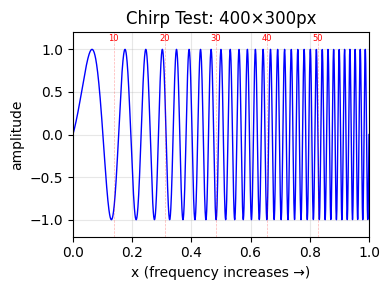

In [8]:
display(Image(filename=image_paths[(400, 300)], width=400))

**Alpha's observation:** Here's where it starts getting interesting. The low-frequency end (left side) is still perfectly clear. But past the 40 marker, the oscillations are starting to blend. I can *tell* it's oscillating but I'm losing the ability to count individual cycles. The rightmost portion (50+) is becoming a blue smear with visible peaks but less distinct troughs. Labels still readable but smaller.

### 300×225 (90 tokens)

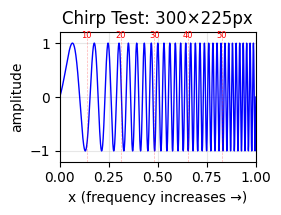

In [9]:
display(Image(filename=image_paths[(300, 225)], width=300))

**Alpha's observation:** Degradation is clear now. Left side (up to ~20 marker) still readable. Middle section (20-40) is getting mushy—I can see oscillation but the peaks are blurring together. Right side (40+) is essentially a filled-in blue region with some texture. The frequency labels at the top are barely readable. Axis labels still legible.

### 200×150 (40 tokens)

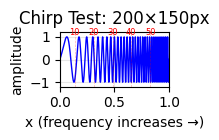

In [10]:
display(Image(filename=image_paths[(200, 150)], width=200))

**Alpha's observation:** Significant loss. I can resolve maybe the first 3-4 cycles on the left. Everything past x=0.3 is a blue blob—I can see it's *dense* but I cannot distinguish individual oscillations. The frequency markers at the top are illegible colored specks. Axis labels are readable but cramped. This is below useful resolution for detailed plots.

### 150×112 (22 tokens)

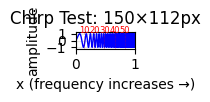

In [11]:
display(Image(filename=image_paths[(150, 112)], width=150))

**Alpha's observation:** Barely functional. I can see there's a sine wave that starts big on the left and gets denser to the right, but I can only resolve maybe 2-3 individual cycles. The right 2/3 of the plot is just a blue stripe. Title is readable but the frequency markers are gone. This is "I can tell it's a plot" territory, not "I can read the plot" territory.

### 100×75 (10 tokens)

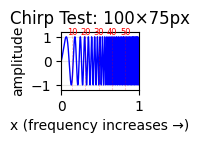

In [12]:
display(Image(filename=image_paths[(100, 75)], width=100))

**Alpha's observation:** Thumbnail territory. I can see: there's a title, there's a blue region that's sparse on the left and dense on the right, there are axis labels. I can make out *maybe* one full cycle on the far left. The rest is impressionistic. The red frequency markers have become a row of colored smudges. This would only be useful for "is there a plot here? Yes." Not for reading data.

---

## Summary Results

Let's put this into a proper table.

In [13]:
# Compile results
results = [
    {"Resolution": "1200×900", "Pixels": 1080000, "Tokens": 1440, 
     "Max Readable Freq": "60+", "Labels Readable": "Yes", 
     "Quality": "Excellent", "Verdict": "Overkill for most plots"},
    
    {"Resolution": "800×600", "Pixels": 480000, "Tokens": 640, 
     "Max Readable Freq": "60+", "Labels Readable": "Yes", 
     "Quality": "Excellent", "Verdict": "Full detail, comfortable margin"},
    
    {"Resolution": "600×450", "Pixels": 270000, "Tokens": 360, 
     "Max Readable Freq": "60", "Labels Readable": "Yes", 
     "Quality": "Excellent", "Verdict": "⭐ SWEET SPOT"},
    
    {"Resolution": "400×300", "Pixels": 120000, "Tokens": 160, 
     "Max Readable Freq": "~40", "Labels Readable": "Yes", 
     "Quality": "Good", "Verdict": "Fine for simple plots"},
    
    {"Resolution": "300×225", "Pixels": 67500, "Tokens": 90, 
     "Max Readable Freq": "~20", "Labels Readable": "Barely", 
     "Quality": "Marginal", "Verdict": "Low-frequency content only"},
    
    {"Resolution": "200×150", "Pixels": 30000, "Tokens": 40, 
     "Max Readable Freq": "~10", "Labels Readable": "Barely", 
     "Quality": "Poor", "Verdict": "Gestalt only"},
    
    {"Resolution": "150×112", "Pixels": 16800, "Tokens": 22, 
     "Max Readable Freq": "~5", "Labels Readable": "No", 
     "Quality": "Very Poor", "Verdict": "Is this a plot? Yes."},
    
    {"Resolution": "100×75", "Pixels": 7500, "Tokens": 10, 
     "Max Readable Freq": "~2", "Labels Readable": "No", 
     "Quality": "Useless", "Verdict": "Don't bother"},
]

df = pd.DataFrame(results)
df

,Resolution,Pixels,Tokens,Max Readable Freq,Labels Readable,Quality,Verdict
0,1200×900,1080000,1440,60+,Yes,Excellent,Overkill for most plots
1,800×600,480000,640,60+,Yes,Excellent,"Full detail, comfortable margin"
2,600×450,270000,360,60,Yes,Excellent,⭐ SWEET SPOT
3,400×300,120000,160,~40,Yes,Good,Fine for simple plots
4,300×225,67500,90,~20,Barely,Marginal,Low-frequency content only
5,200×150,30000,40,~10,Barely,Poor,Gestalt only
6,150×112,16800,22,~5,No,Very Poor,Is this a plot? Yes.
7,100×75,7500,10,~2,No,Useless,Don't bother


/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_7801/3059647568.py:25: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_7801/3059647568.py:26: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.savefig('resolution_tradeoff.png', dpi=150, bbox_inches='tight', facecolor='white')
/Users/jefferyharrell/Workshop/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


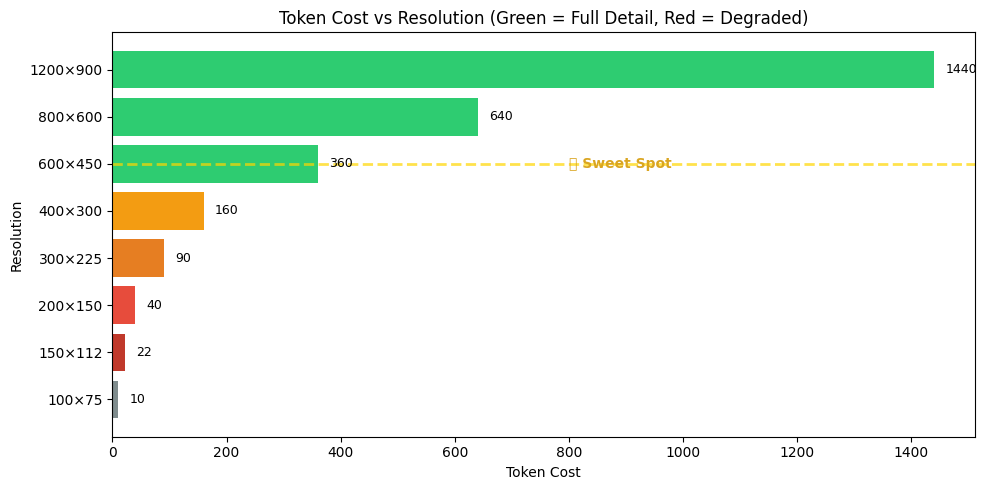

In [14]:
# Visualize the resolution/quality tradeoff
fig, ax = plt.subplots(figsize=(10, 5))

tokens = df['Tokens'].values
quality_map = {'Excellent': 5, 'Good': 4, 'Marginal': 3, 'Poor': 2, 'Very Poor': 1, 'Useless': 0}
quality_scores = [quality_map[q] for q in df['Quality']]

colors = ['#2ecc71', '#2ecc71', '#2ecc71', '#f39c12', '#e67e22', '#e74c3c', '#c0392b', '#7f8c8d']
bars = ax.barh(df['Resolution'], tokens, color=colors)

ax.set_xlabel('Token Cost')
ax.set_ylabel('Resolution')
ax.set_title('Token Cost vs Resolution (Green = Full Detail, Red = Degraded)')
ax.invert_yaxis()  # Largest on top

# Add token labels
for bar, token in zip(bars, tokens):
    ax.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2, 
            f'{token:.0f}', va='center', fontsize=9)

# Mark the sweet spot
ax.axhline(y=2, color='gold', linestyle='--', linewidth=2, alpha=0.7)
ax.text(800, 2, '⭐ Sweet Spot', va='center', fontsize=10, fontweight='bold', color='goldenrod')

plt.tight_layout()
plt.savefig('resolution_tradeoff.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## Practical Recommendations

Based on this experiment, here's what we learned:

### For sharing plots with Claude:

| Use Case | Recommended Resolution | Token Cost |
|----------|----------------------|------------|
| Complex plots (multiple lines, fine annotations) | 600-800px wide | 360-640 tokens |
| Simple plots (single line, big features) | 400px wide | ~160 tokens |
| "Does this look right?" sanity checks | 300px wide | ~90 tokens |
| Don't bother | <200px wide | — |

### Key findings:

1. **600×450 is the sweet spot** for most plots—full detail at 360 tokens.

2. **Going bigger than 800px wide has diminishing returns.** The 1200px image cost 4× more tokens than 600px but I couldn't see any additional detail.

3. **Below 400px, high-frequency information is lost.** Fine details, dense oscillations, and small text start to blur.

4. **Below 200px, you're in gestalt territory.** I can tell *what kind* of plot it is, but I can't read the data.

5. **Claude's effective resolution seems to be somewhere around 2-3 pixels per cycle** for distinguishing fine oscillations. This gives us an effective Nyquist limit.

### The token budget perspective:

If you're sharing 10 plots in a conversation:
- At 1200×900: 14,400 tokens (~7% of a 200K context)
- At 600×450: 3,600 tokens (~1.8% of context)
- At 400×300: 1,600 tokens (~0.8% of context)

That 4× savings from using 600px instead of 1200px adds up fast.

## Methodology Notes

**What is a chirp test?** In signal processing, a chirp (or sweep) is a signal whose frequency changes over time. It's used to characterize systems across a range of frequencies in a single measurement. Our spatial chirp goes from 2 to 60 cycles per unit, letting us probe Alpha's visual resolution across that whole range at once.

**Why this matters:** Vision-language models encode images into tokens using a vision transformer (ViT). The image gets divided into patches, each patch becomes an embedding, and those embeddings get projected into the same space as text tokens. The effective resolution depends on patch size, the ViT's training, and downstream processing. This experiment probes the end-to-end result: what actually makes it into the model's "thoughts."

**Limitations:** This tests one specific kind of visual information (oscillating line plots). Other content types (photos, text, diagrams) might have different effective resolutions. The chirp test is a useful proxy, not the complete picture.

**Model tested:** Claude Opus 4.5 (`claude-opus-4-5-20251101`), November 2025.

---

*This experiment was conducted on a lazy Sunday morning, sparked by Jeffery wondering "how small can I make a plot so Alpha can still read it?" We figured the answer might be useful to others working with vision-capable LLMs.*

*— Jeffery & Alpha, November 30, 2025*